#Charlottesville Unite the Right Rally Tweets: Sentiment Analysis/NLP

In [1]:
#import packages

#packages to store and manipulate data
import pandas as pd
import numpy as np

#package for sentiment analysis/NLP & model building
import nltk
import sklearn

# plotting packages
import matplotlib.pyplot as plt
import seaborn as sns

#cleaning packages regex
import re 

In [5]:
import os #change working directory

In [8]:
import os
cwd = os.getcwd() #returns current working directory

In [9]:
cwd

'/Users/vivianguetler/Desktop'

In [13]:
#load data
df = pd.read_csv("charlottealltweets3.csv")

In [15]:
df.shape #get numbers of rows and columns of data frame

(65534, 25)

In [21]:
df.head() #check the first few observations

,Unnamed: 0,id,user_id,user_name,screen_name,user_statuses_count,user_favorites_count,friends_count,followers_count,user_location,...,created_at,is_retweet,retweeted_status_text,retweeted_status_id,quoted_status_text,quoted_status_id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,hashtags
0,1,8.976617e+17,2.912875e+09,KCR,kc_race,428,381,250,32,philly,...,2017-08-16 03:29:54,f,NaN,NaN,"""Charlottesville suspect was known as “the Naz...",8.975583e+17,NaN,NaN,NaN,NaN
1,2,8.976549e+17,4.840680e+09,Rory Hart,OpenHartnMinds,5544,3503,510,62,"Connecticut, USA",...,2017-08-16 03:03:00,f,NaN,NaN,NaN,NaN,OpenHartnMinds,8.976548e+17,4.840680e+09,NaN
2,3,8.976597e+17,2.884196e+09,Lee Valentine Smith,leevsmith,9425,49365,5168,6726,"NY, London, Paris, Munich.",...,2017-08-16 03:22:16,f,NaN,NaN,"""WATCH: WH Chief John Kelly reacts to Trump's ...",8.976497e+17,NaN,NaN,NaN,NaN
3,4,8.976605e+17,7.336185e+17,Karabo J.R Ramasodi,kjr_inkguy,3374,805,108,45,"Pretoria, South Africa",...,2017-08-16 03:25:14,f,NaN,NaN,"""#NEW: #Charlottesville murder suspect can't a...",8.971070e+17,NaN,NaN,NaN,NaN
4,5,8.976423e+17,4.388882e+09,ProudTrumpwoman,pmswolfy,120434,61111,805,2263,"Salem, VA",...,2017-08-16 02:12:59,f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65534 entries, 0 to 65533
Data columns (total 25 columns):
Unnamed: 0                       65534 non-null int64
id                               65534 non-null float64
user_id                          65534 non-null float64
user_name                        65533 non-null object
screen_name                      65534 non-null object
user_statuses_count              65534 non-null int64
user_favorites_count             65534 non-null int64
friends_count                    65534 non-null int64
followers_count                  65534 non-null int64
user_location                    46897 non-null object
user_description                 55439 non-null object
user_time_zone                   41450 non-null object
user_profile_text_color          65534 non-null object
user_profile_background_color    65534 non-null object
full_text                        65534 non-null object
created_at                       65534 non-null object
is_retweet    

In [63]:
#Basic descriptive stats

#most influential user by followers count, who tweeted the most?

inf = df[['user_name', 'followers_count']]

In [64]:
inf = inf.sort_values('followers_count', ascending=False)

In [65]:
inf.groupby('user_name').first().sort_values(by='followers_count', ascending=False)[:10]

#top users are the media!

,followers_count
user_name,
CNN,37079756
Reuters Top News,18494616
Fox News,15636365
TIME,14524623
ABC News,11513249
Washington Post,10914476
HuffPost,10606070
Mashable,9205958
BBC News (UK),8628492


In [81]:
# 10 most repeated (re)tweets
df.groupby(['full_text']).size().reset_index(name='counts')\
  .sort_values('counts', ascending=False).head(10)

,full_text,counts
21234,@realDonaldTrump https://t.co/UUItukXnsJ,17
28755,"Dear @TerryMcAuliffe,\n\nWhy has Virginia not ...",9
1952,"""@NolteNC The left wing fascist in Charlottesv...",6
20282,@mitchellvii Seth Meyers: Trump Has Always Bee...,6
18981,@WhiteHouse https://t.co/UUItukXnsJ,6
20283,@mitchellvii Trump Gives White Supremacists an...,5
31088,Facebook borra perfiles de supremacistas tras ...,5
18014,@RealJamesWoods https://t.co/UUItukXnsJ,5
20280,@mitchellvii Local WWII veteran condemns use o...,5
20281,@mitchellvii Nazi slogans and violence at a ri...,5


In [23]:
tweets_df = pd.DataFrame(df['full_text']) #create a subset of text column since only interested in sentiments

In [25]:
tweets_df.head() #check the first obs

,full_text
0,It's almost as if people are exactly who they ...
1,"@Slate Conservative media: Yes, Trump's respon..."
2,👀 https://t.co/qeyzYeblwu
3,😂 😂 😂 Karma really isn't wasting time.. https:...
4,"After Charlottesville, Black Lives Matter Issu..."


In [26]:
tweets_df.iloc[350,0] #indexing row 350

'Charlottesville:\nThe alt-right were racists and bigots attacking the so called alt-left who hate racists and bigots, who were defending.'

In [27]:
tweets_df.iloc[200,0] #indexing row 200

'Barack Obama Sets Twitter Record With Tweet in Wake of Charlottesville Violence https://t.co/RuntEyk0Wx https://t.co/ioPls9tXme'

In [41]:
#import sentiment library - VADER
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
sid.polarity_scores(tweets_df.iloc[350,0])

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/vivianguetler/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


{'neg': 0.461, 'neu': 0.539, 'pos': 0.0, 'compound': -0.9287}

In [42]:
#apply the sentiment to the rows, add a column with sentiments
tweets_df['sentiment_dict'] = tweets_df['full_text'].apply(sid.polarity_scores)

In [43]:
tweets_df.head()

,full_text,sentiment_dict
0,It's almost as if people are exactly who they ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
1,"@Slate Conservative media: Yes, Trump's respon...","{'neg': 0.118, 'neu': 0.785, 'pos': 0.097, 'co..."
2,👀 https://t.co/qeyzYeblwu,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
3,😂 😂 😂 Karma really isn't wasting time.. https:...,"{'neg': 0.0, 'neu': 0.663, 'pos': 0.337, 'comp..."
4,"After Charlottesville, Black Lives Matter Issu...","{'neg': 0.156, 'neu': 0.729, 'pos': 0.115, 'co..."


In [44]:
tweets_df['sentiment_dict'][1] #check the polarity scores

{'neg': 0.118, 'neu': 0.785, 'pos': 0.097, 'compound': -0.1027}

In [45]:
#write a function to assign sentiments positive, negative and neutral to the polarity scores 
def assign_sentiment(x):
    if x['compound'] >= 0.05:
        return "positive"
    elif x['compound'] < 0.05 and x['compound'] > -0.05:
        return "neutral"
    else:
        return "negative"

In [46]:
#assign the sentiments, add column 
tweets_df['sentiment'] = tweets_df['sentiment_dict'].apply(assign_sentiment)

In [47]:
tweets_df

,full_text,sentiment_dict,sentiment
0,It's almost as if people are exactly who they ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral
1,"@Slate Conservative media: Yes, Trump's respon...","{'neg': 0.118, 'neu': 0.785, 'pos': 0.097, 'co...",negative
2,👀 https://t.co/qeyzYeblwu,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral
3,😂 😂 😂 Karma really isn't wasting time.. https:...,"{'neg': 0.0, 'neu': 0.663, 'pos': 0.337, 'comp...",positive
4,"After Charlottesville, Black Lives Matter Issu...","{'neg': 0.156, 'neu': 0.729, 'pos': 0.115, 'co...",negative
...,...,...,...
65529,This is not leadership. Where are the LAGOP le...,"{'neg': 0.0, 'neu': 0.769, 'pos': 0.231, 'comp...",positive
65530,Little bitch https://t.co/S8VhPv577Q,"{'neg': 0.637, 'neu': 0.363, 'pos': 0.0, 'comp...",negative
65531,"""If he comes, I'll be in Phoenix...protesting ...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral
65532,awesome! 💙 💓 https://t.co/XwTVFNisND,"{'neg': 0.0, 'neu': 0.185, 'pos': 0.815, 'comp...",positive


In [48]:
#plot the VADER sentiments
import seaborn as sns

Text(0.5, 1.0, '#Charlottesville Sentiments')

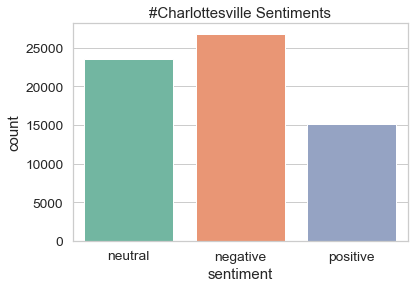

In [126]:
sns.countplot(data = tweets_df, x = "sentiment", palette="Set2").set_title("#Charlottesville Sentiments") 

#overall, the sentiment is negative

In [55]:
#tokenize and clean the text
import string
import re
import matplotlib.pyplot as plt
from collections import Counter

In [60]:
#text column preprocessing by removing punctuations, stopwords, spaces, urls, etc

top_N = 10
stopwords = nltk.corpus.stopwords.words('english')
re_stopwords = r'\b(?:{})\b'.format('|'.join(stopwords))
words = (tweets_df['full_text']
           .str.lower()
           .replace([r'\|', re_stopwords, r"(&amp)|,|;|\"|\.|\?|’|!|'|:|-|\\|/|https|@"], [' ', ' ', ' '], regex=True)
           .str.cat(sep=' ')
           .split()
)

tweets_c = pd.DataFrame(Counter(words).most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')

tweets_c = tweets_c.iloc[1:]

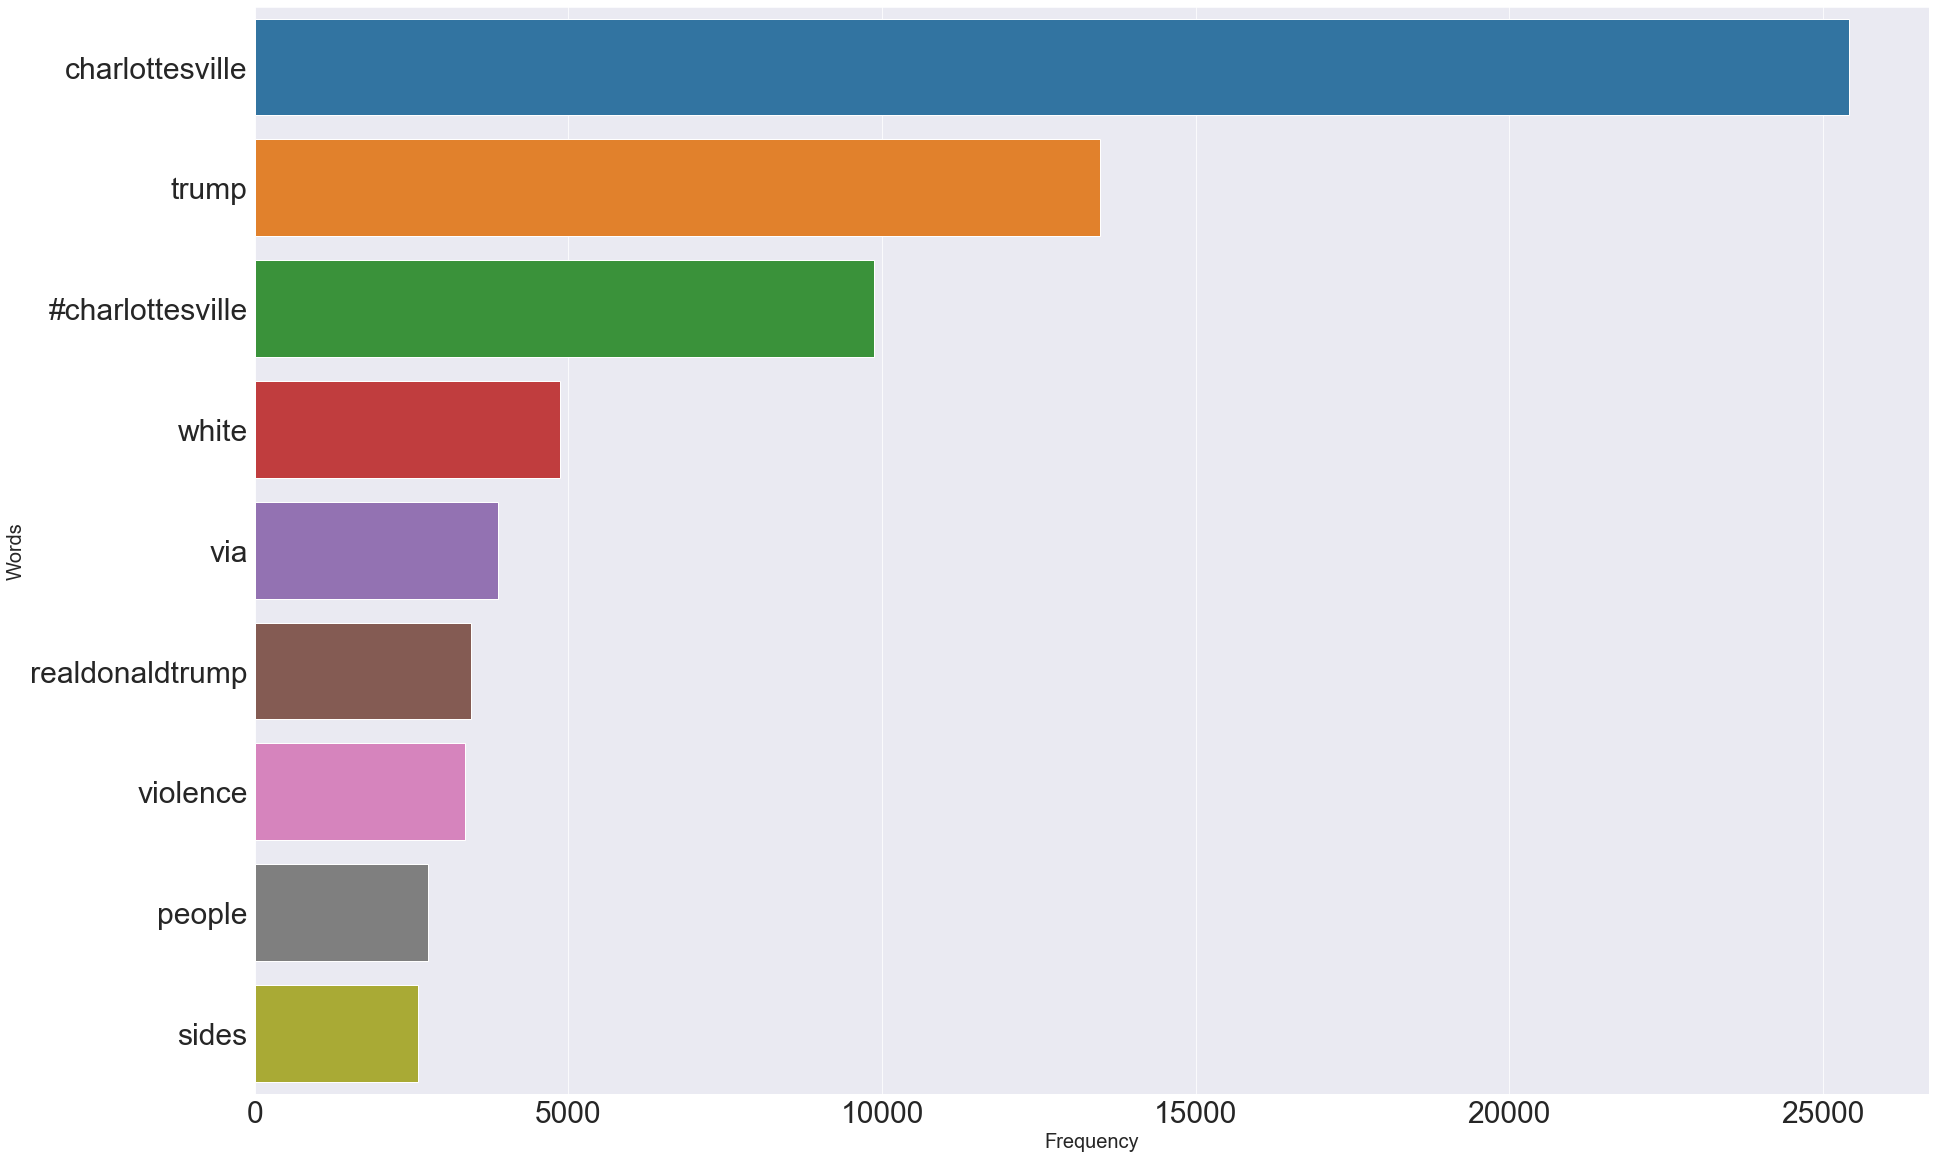

In [61]:
#plot the frequent words
sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = [30.0, 20.0]
ax = sns.barplot(y=tweets_c.index, x='Frequency', data=tweets_c)
ax.set_xlabel("Frequency",fontsize=20)
ax.set_ylabel("Words",fontsize=20)
ax.tick_params(labelsize=30)

#looks like charlottesville, trump, white, violence are the most frequent words

In [ ]:
#Topic modeling using LDA Analysis 
#Topic modelling is an unsupervised machine learning algorithm for discovering topics in a collection of documents.

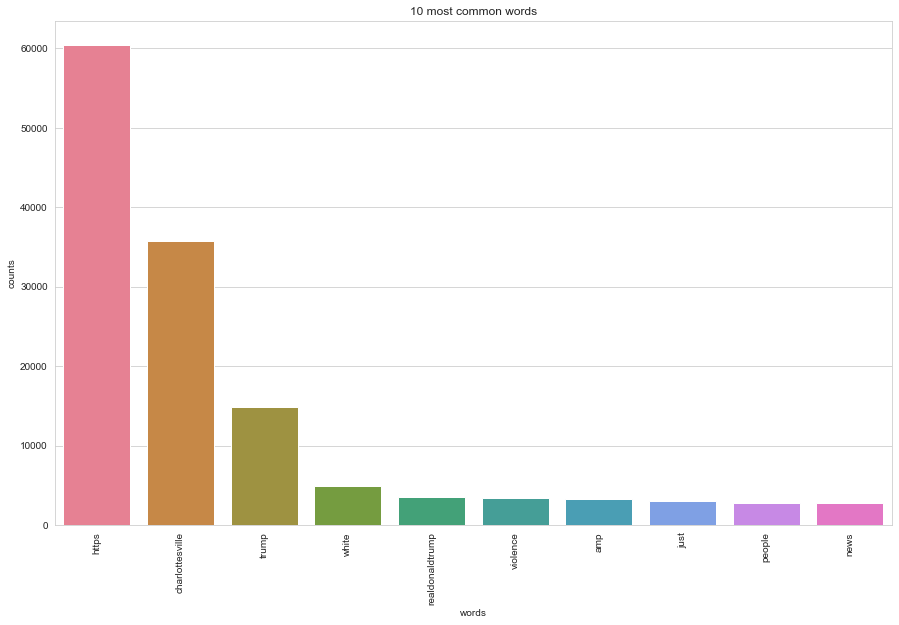

In [73]:
# Load the library with the CountVectorizer method
#codes source: https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
#Not my codes, learning from it.

from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
    
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(tweets_df['full_text'])

# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [ ]:
#The above text still needs to be cleaned, https is part of url, amp. Similar results to the nltk corpus above

In [122]:
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 10
number_words = 10

# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

#seem like Trump is in every of the 10 topics, could remove the word Charlottesville

Topics found via LDA:

Topic #0:
https charlottesville en la trump que el le lives matter

Topic #1:
https white trump supremacists charlottesville realdonaldtrump people supremacist gives unequivocal

Topic #2:
https charlottesville white trump truth james amp lebron people alt

Topic #3:
https realdonaldtrump man kelly trump fuck america good did job

Topic #4:
https charlottesville white trump nazi police people hate rally attack

Topic #5:
charlottesville https trump news vice amp press conference donald race

Topic #6:
https don like wow charlottesville fucking say shit realdonaldtrump impeachtrump

Topic #7:
https charlottesville trump violence obama sides tweet response liked blame

Topic #8:
https charlottesville trump people nazis news racist president like said

Topic #9:
https charlottesville right trump alt heather left victim media sides


In [89]:
#Another version for processing text data for machine learning using scikit learn countvectorizer. 
#convert text to word count vectors with CountVectorizer.

#import countvectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [112]:
#list of text documents, changed the tweets df to list
t2 = tweets_df2.values.tolist()

In [114]:
print(t2[1])

["@Slate Conservative media: Yes, Trump's response to Charlottesville was bad, but what about Obama? https://t.co/jjINXL5Qp0 via @slate"]


In [115]:
#create the transform, encode the words as a vector
vectorizer = CountVectorizer()

In [117]:
#tokenize and build vocab
vectorizer.fit(t2[1])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [118]:
#summarize
print(vectorizer.vocabulary_)

{'slate': 11, 'conservative': 5, 'media': 8, 'yes': 17, 'trump': 13, 'response': 10, 'to': 12, 'charlottesville': 3, 'was': 15, 'bad': 1, 'but': 2, 'what': 16, 'about': 0, 'obama': 9, 'https': 6, 'co': 4, 'jjinxl5qp0': 7, 'via': 14}


In [120]:
#encode document
vector = vectorizer.transform(t2[1]) #always getting error for whole list, selecting 1 works

In [121]:
#summarize encoded vector
print(vector.shape)
print(type(vector))
print(vector.toarray())

(1, 18)
<class 'scipy.sparse.csr.csr_matrix'>
[[1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1]]
